In [1]:
import pandas as pd
import finterstellar as fs

데이터 로딩

In [2]:
coin = fs.CoinPrice()

In [3]:
cd = 'BTC'

In [4]:
df = coin.bithumb_historical_price(cd)
df.head()

,close,open,high,low,volume
2019-06-07 19:40:00,9703000.0,9699000.0,9703000.0,9699000.0,2.1641
2019-06-07 19:41:00,9707000.0,9703000.0,9707000.0,9702000.0,3.2506
2019-06-07 19:42:00,9710000.0,9706000.0,9711000.0,9706000.0,9.9665
2019-06-07 19:43:00,9710000.0,9713000.0,9714000.0,9710000.0,1.5794
2019-06-07 19:44:00,9712000.0,9710000.0,9719000.0,9710000.0,1.9109


Moving average 구하기

In [5]:
short = 10    # 단기 기준
mid = 60    # 중기 기준

In [6]:
ma = pd.DataFrame()
ma[cd] = df['close']
ma['short'] = df['close'].rolling(short).mean()   # 데이터프레임[데이터].rolling(기준일자).mean() - 이동평균 계산
ma['mid'] = df['close'].rolling(mid).mean()
ma.tail(10)

,BTC,short,mid
2019-06-08 19:30:00,9758000.0,9752800.0,9.727917e+06
2019-06-08 19:31:00,9757000.0,9753500.0,9.729033e+06
2019-06-08 19:32:00,9752000.0,9752700.0,9.730083e+06
2019-06-08 19:33:00,9748000.0,9752500.0,9.731033e+06
2019-06-08 19:34:00,9750000.0,9751800.0,9.731917e+06
2019-06-08 19:35:00,9745000.0,9751200.0,9.732800e+06
2019-06-08 19:36:00,9750000.0,9751400.0,9.733800e+06
2019-06-08 19:37:00,9750000.0,9751500.0,9.734783e+06
2019-06-08 19:38:00,9745000.0,9751100.0,9.735700e+06
2019-06-08 19:39:00,9745000.0,9750000.0,9.736617e+06


In [7]:
base_date = df.index[0]   # 기준점 설정
ma = ma[base_date:].copy()    # 기준일 이후 데이터만 가져와 ma에 저장
ma.head()

,BTC,short,mid
2019-06-07 19:40:00,9703000.0,NaN,NaN
2019-06-07 19:41:00,9707000.0,NaN,NaN
2019-06-07 19:42:00,9710000.0,NaN,NaN
2019-06-07 19:43:00,9710000.0,NaN,NaN
2019-06-07 19:44:00,9712000.0,NaN,NaN


그래프 그리기 (fs 라이브러리 이용)

In [8]:
v = fs.VisualizeIntraday()      # fs 라이브러리의 Visualize() 모듈을 불러와 v로 지정

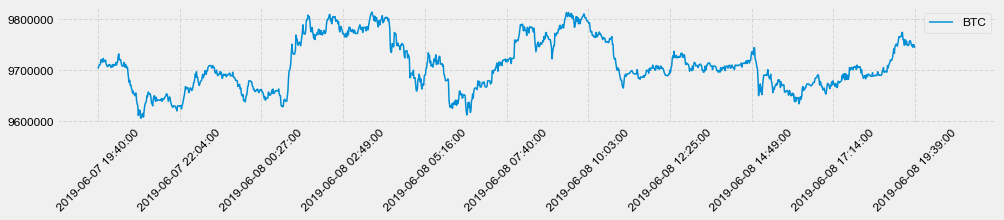

In [9]:
v.price_view(ma, base_date, cd, (15, 2), make_file=False)
# price_view(데이터프레임, 기준일자, [비교대상(복수종목)], (챠트사이즈)) 함수 - 그래프 그리기

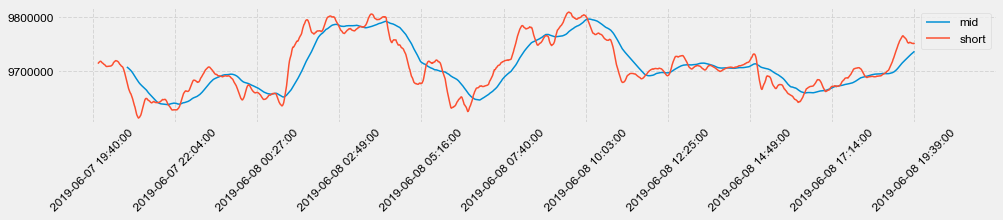

In [10]:
v.price_view(ma, base_date, ['mid', 'short'], (15, 2))
# price_view(데이터프레임, 기준일자, [비교대상(복수종목)], (챠트사이즈)) 함수 - 그래프 그리기

# MA로 트레이딩을 한다면?

short과 mid가 교차할 때 매매하는 로직을 세우기 위해

In [11]:
ma['s-m'] = ma['short'] - ma['mid']
ma.tail(3)
# 그렇다면, s-m 값이 +라면 상승추세인걸로

,BTC,short,mid,s-m
2019-06-08 19:37:00,9750000.0,9751500.0,9.734783e+06,16716.666667
2019-06-08 19:38:00,9745000.0,9751100.0,9.735700e+06,15400.000000
2019-06-08 19:39:00,9745000.0,9750000.0,9.736617e+06,13383.333333


In [12]:
def trend_tradings(sample, book, cd, factor):
    for i in sample.index:    # 시세를 하나씩 읽어가며
        if sample.loc[i, factor] >= 0:   # 상승추세라면
            book.loc[i, 't '+cd] = 'buy'    # buy해라
        elif sample.loc[i, factor] < 0:    # 하락추세라면
            book.loc[i, 't '+cd] = ''    # 털어라
    return (book) 

백테스팅을 위한 트레이드 북 생성

In [13]:
trd = fs.Trade()   # fs 라이브러리의 Trade() 모듈을 불러와 trd로 지정

In [14]:
book = trd.create_trade_book(ma, [cd])    
# trd 모듈의 create_trade_book(데이터프레임, [종목코드]) 함수를 이용해 트레이딩북 생성
book.tail()

,BTC,t BTC,p BTC
2019-06-08 19:35:00,9745000.0,,
2019-06-08 19:36:00,9750000.0,,
2019-06-08 19:37:00,9750000.0,,
2019-06-08 19:38:00,9745000.0,,
2019-06-08 19:39:00,9745000.0,,


트렌드 트레이딩 전략 실행

In [15]:
book = trend_tradings(ma, book, cd, 's-m')
book.tail()

,BTC,t BTC,p BTC
2019-06-08 19:35:00,9745000.0,buy,
2019-06-08 19:36:00,9750000.0,buy,
2019-06-08 19:37:00,9750000.0,buy,
2019-06-08 19:38:00,9745000.0,buy,
2019-06-08 19:39:00,9745000.0,buy,


포지션 산출

In [16]:
book = trd.position(book, [cd])
# position(트레이딩북, 종목코드) - 매매전략에 따른 포지션을 판단해 트레이딩북에 기록
book.tail()

,BTC,t BTC,p BTC
2019-06-08 19:35:00,9745000.0,buy,ll
2019-06-08 19:36:00,9750000.0,buy,ll
2019-06-08 19:37:00,9750000.0,buy,ll
2019-06-08 19:38:00,9745000.0,buy,ll
2019-06-08 19:39:00,9745000.0,buy,ll


손익 계산

In [17]:
fund_rtn = trd.returns(book, cd, display=True)
# returns(트레이딩북, 종목코드) - 백테스팅 수익률 계산

2019-06-07 21:34:00 long BTC 9642000.0
2019-06-07 21:52:00 long BTC 9642000.0  | unwind long BTC 9630000.0  | return: 0.9988
2019-06-07 22:14:00 long BTC 9668000.0
2019-06-07 23:24:00 long BTC 9668000.0  | unwind long BTC 9692000.0  | return: 1.0025
2019-06-08 00:53:00 long BTC 9660000.0
2019-06-08 00:58:00 long BTC 9660000.0  | unwind long BTC 9653000.0  | return: 0.9993
2019-06-08 01:15:00 long BTC 9698000.0
2019-06-08 02:48:00 long BTC 9698000.0  | unwind long BTC 9773000.0  | return: 1.0077
2019-06-08 03:27:00 long BTC 9784000.0
2019-06-08 03:30:00 long BTC 9784000.0  | unwind long BTC 9777000.0  | return: 0.9993
2019-06-08 03:31:00 long BTC 9785000.0
2019-06-08 04:15:00 long BTC 9785000.0  | unwind long BTC 9735000.0  | return: 0.9949
2019-06-08 05:25:00 long BTC 9714000.0
2019-06-08 05:53:00 long BTC 9714000.0  | unwind long BTC 9680000.0  | return: 0.9965
2019-06-08 06:46:00 long BTC 9665000.0
2019-06-08 08:37:00 long BTC 9665000.0  | unwind long BTC 9747000.0  | return: 1.0085


벤치마크 수익률 계산

In [18]:
bm_rtn = trd.benchmark_return(book, [cd])
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률(전략 미이용시) 계산

BM return: 0.43 %
{'BTC': 1.0043}


In [19]:
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 전략의 벤치마크 대비 초과수익률 계산

Excess return: -0.73 %
